In [2]:
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [0]:
!unzip -q drive/'My Drive'/dataset-original.zip

In [0]:
!mkdir dataset-validation
!mkdir dataset-validation/cardboard
!mkdir dataset-validation/glass
!mkdir dataset-validation/paper
!mkdir dataset-validation/plastic
!mkdir dataset-validation/metal
!mkdir dataset-validation/trash
!ls
!ls dataset-original/trash

dataset-original  dataset-validation  drive  __MACOSX  sample_data
trash100.jpg  trash121.jpg  trash18.jpg  trash39.jpg  trash5.jpg   trash80.jpg
trash101.jpg  trash122.jpg  trash19.jpg  trash3.jpg   trash60.jpg  trash81.jpg
trash102.jpg  trash123.jpg  trash1.jpg	 trash40.jpg  trash61.jpg  trash82.jpg
trash103.jpg  trash124.jpg  trash20.jpg  trash41.jpg  trash62.jpg  trash83.jpg
trash104.jpg  trash125.jpg  trash21.jpg  trash42.jpg  trash63.jpg  trash84.jpg
trash105.jpg  trash126.jpg  trash22.jpg  trash43.jpg  trash64.jpg  trash85.jpg
trash106.jpg  trash127.jpg  trash23.jpg  trash44.jpg  trash65.jpg  trash86.jpg
trash107.jpg  trash128.jpg  trash24.jpg  trash45.jpg  trash66.jpg  trash87.jpg
trash108.jpg  trash129.jpg  trash25.jpg  trash46.jpg  trash67.jpg  trash88.jpg
trash109.jpg  trash12.jpg   trash26.jpg  trash47.jpg  trash68.jpg  trash89.jpg
trash10.jpg   trash130.jpg  trash27.jpg  trash48.jpg  trash69.jpg  trash8.jpg
trash110.jpg  trash131.jpg  trash28.jpg  trash49.jpg  trash6.jpg  

In [0]:
!shuf -n 101 -e dataset-original/glass/* | xargs -i mv {} dataset-validation/glass/
!shuf -n 144 -e dataset-original/paper/* | xargs -i mv {} dataset-validation/paper/
!shuf -n 53 -e dataset-original/cardboard/* | xargs -i mv {} dataset-validation/cardboard/
!shuf -n 82 -e dataset-original/plastic/* | xargs -i mv {} dataset-validation/plastic/
!shuf -n 60 -e dataset-original/metal/* | xargs -i mv {} dataset-validation/metal/
!shuf -n 37 -e dataset-original/trash/* | xargs -i mv {} dataset-validation/trash/

In [0]:
!ls dataset-original/glass | wc -l
!ls dataset-validation/glass | wc -l

400
101


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np

In [0]:
transformationsTrain = transforms.Compose([transforms.Resize(299), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(degrees = (90, -90)), transforms.ToTensor(), 
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformationsValidation = transforms.Compose([transforms.Resize(255), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
train_set = datasets.ImageFolder("dataset-original", transform = transformationsTrain)
val_set = datasets.ImageFolder("dataset-validation", transform = transformationsValidation)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=25, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =25, shuffle=True)

In [0]:
!/opt/bin/nvidia-smi
!ps -aux|grep python

Mon Dec  2 14:53:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# torch.cuda.empty_cache()
# !kill -9 877

In [0]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()

minibatches = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.data.max(1)[1]
        matches = labels == pred
        accuracy = matches.float().mean()

        # print statistics
        running_loss += loss.item()
        if i % minibatches == minibatches - 1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f itemLoss: %.3f' %
                  (epoch + 1, i + 1, running_loss / minibatches, accuracy, loss.item()))
            running_loss = 0.0

        train_losses.append(loss.item())
        train_accs.append(accuracy.item())
    
    model.eval()
    val_loss, correct = 0., 0
    total = 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

    val_loss /= len(val_loader)
    acc = correct / len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(acc)

print('Finished Training')

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 78.2MB/s]


[1,     5] loss: 6.585 accuracy: 0.400 itemLoss: 4.173
[1,    10] loss: 2.525 accuracy: 0.640 itemLoss: 1.869
[1,    15] loss: 1.397 accuracy: 0.520 itemLoss: 1.465
[1,    20] loss: 1.045 accuracy: 0.880 itemLoss: 0.737
[1,    25] loss: 0.874 accuracy: 0.680 itemLoss: 0.945
[1,    30] loss: 1.014 accuracy: 0.800 itemLoss: 0.611
[1,    35] loss: 0.704 accuracy: 0.840 itemLoss: 0.540
[1,    40] loss: 0.575 accuracy: 0.880 itemLoss: 0.281
[1,    45] loss: 0.576 accuracy: 0.800 itemLoss: 0.507
[1,    50] loss: 0.365 accuracy: 0.880 itemLoss: 0.289
[1,    55] loss: 0.434 accuracy: 0.880 itemLoss: 0.311
[1,    60] loss: 0.499 accuracy: 0.760 itemLoss: 0.583
[1,    65] loss: 0.535 accuracy: 0.880 itemLoss: 0.373
[1,    70] loss: 0.496 accuracy: 0.840 itemLoss: 0.320
[1,    75] loss: 0.524 accuracy: 0.800 itemLoss: 0.524
[1,    80] loss: 0.756 accuracy: 0.600 itemLoss: 1.431
Accuracy of the network on the validation images: 86.373166 %
[2,     5] loss: 0.410 accuracy: 0.840 itemLoss: 0.439
[2,

In [0]:
# torch.save(model.state_dict(), "/content/drive/My Drive/modelDec2.pt")

In [0]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
model.load_state_dict(torch.load("/content/drive/My Drive/modelDec2.pt"))

<All keys matched successfully>

In [0]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [0]:
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_labels = all_labels.cuda()
    all_preds = all_preds.cuda()
    for batch in loader:
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

In [0]:
model.eval()

with torch.no_grad():
    prediction_loader = val_loader
    val_preds, val_labels = get_all_preds(model, prediction_loader)

In [0]:
val_labels.shape
# torch.Tensor(val_preds.argmax(dim=1)).shape

torch.Size([477])

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
preds_correct = get_num_correct(val_preds, val_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(val_set))

total correct: 457
accuracy: 0.9580712788259959


In [0]:
stacked = torch.stack(
    (
        val_labels
        ,val_preds.argmax(dim=1).float()
    )
    ,dim=1
)

In [0]:
cmt = torch.zeros(6, 6, dtype=torch.int64)
stacked.shape

torch.Size([477, 2])

In [0]:
for p in stacked.int():
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

tensor([[ 50,   0,   1,   1,   0,   1],
        [  0, 100,   1,   0,   0,   0],
        [  0,   1,  59,   0,   0,   0],
        [  0,   0,   0, 139,   2,   3],
        [  0,   2,   2,   0,  78,   0],
        [  0,   1,   1,   3,   1,  31]])

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(val_labels.cpu(), val_preds.argmax(dim=1).cpu())


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    print(plt.ylim())
    plt.ylim(5.5, -0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class_names = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

Confusion matrix, without normalization
[[ 50   0   1   1   0   1]
 [  0 100   1   0   0   0]
 [  0   1  59   0   0   0]
 [  0   0   0 139   2   3]
 [  0   2   2   0  78   0]
 [  0   1   1   3   1  31]]
(5.0, 0.0)


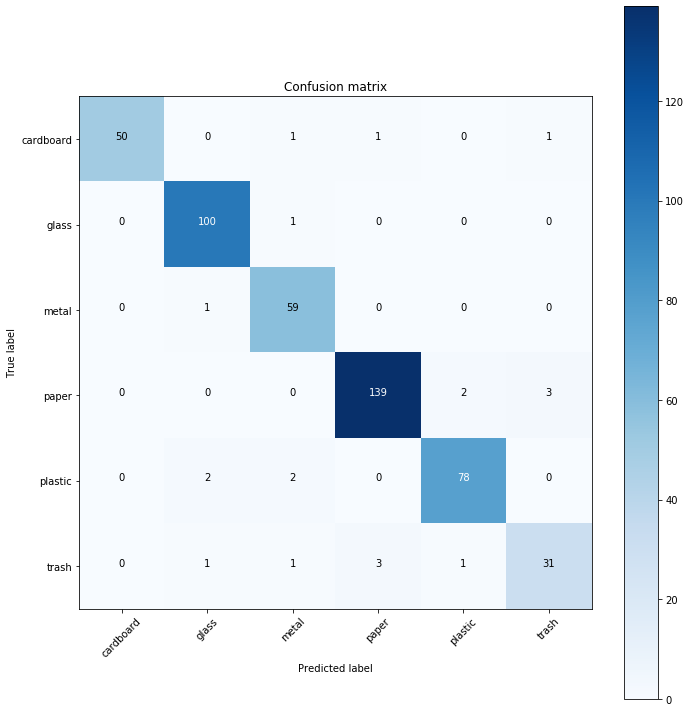

In [0]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_total, y_pred_total, classes=val_set.class_to_idx,
                      title='Confusion matrix, without normalization')

ValueError: ignored

In [0]:
val_set.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}